# <center> DATA 512 A7 - Project Report </center>
<center>Madalyn Li <br>
Fall 2021</center>

The purpose of this project is to expand on the datafication of Covid-19. Specifically, the analysis for this project will focus on acquiring insights about how Yelp consumer reviews for restaurants within Wake County, NC were impacted during the course of the pandemic. The impact of this work will bring valuable insights that can potentially help drive revenue back into the restaurant industry and help re-establish trust between consumers and restaurants by promoting a public environment in which customers feel safer and at ease. 

The data used for this project is derived from the [Restaurants in Wake County](https://data-wake.opendata.arcgis.com/datasets/Wake::restaurants-in-wake-county-yelp/about) dataset, Kaggle's [Daily COVID-19 Data Repository](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv), and the [Yelp Fusion API](https://www.yelp.com/developers/documentation/v3). The results for this project will produce 2 time series graphs for the average Yelp ratings and for the number of Yelp reviews, comparing the monthly change in these values over time between restuarants that offered takeout/delivery vs. those that did not offer takeout/delivery. Both these graphs will also include a secondary axis for monthly total of confirmed COVID-19 cases in order to easily see the start of the pandemic as well as the various waves that occured throughout its course. Finally, this project will also supplement a simple pie chart displaying the proportion of restaurants offering takeout/delivery and those that did not in order to help users gauge and understand the proportion of restaurants within Wake County that did implement measures to adapt to the pandemic.

#### This notebook is divided into 6 general sections:
1. Acquiring Data from the Yelp Fusion API
2. Cleaning & Merging Data
3. Chi-Squared Test Validation
4. Acquiring and Cleaning Covid-19 Data
5. Analyzing Data
6. Graphing Results

In [36]:
import pandas as pd
import numpy as np
import requests
import json
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### 1. Acquiring Data from the Yelp Fusion API

In the first step, our goal is to obtain and query data on information regarding restaurants within Wake County from the [Yelp Fusion API](https://www.yelp.com/developers/documentation/v3). 

**Wake County Restaurant Data**<br>

The first dataset: *Restaurants_in_Wake_County_-_Yelp.csv* is acquired from the Wake County government website and includes a list of all restaurants on Yelp that are in Wake County with some additional information about these restaurants that are highlighted below:

1. **BUSINESS ID**: Contains a unique business id for each restaurant
2. **NAME**: Contains the name of the restaurant
3. **ADDRESS**: Contains the address of the restaurant
4. **CITY**: Contains the city of the restaurant
5. **STATE**: Contains the state of the restaurant
6. **POSTAL CODE**: Contains the zip code of the restaurant
7. **LATITUDE**: Contains the latitude coordinates of the restaurant
8. **LONGITUDE**: Contains the longitutde coordinates of the restaurant
9. **PHONE NUMBER**: Contains the unique phone number of the restaurant

We will use this data set to isolate a list of phone numbers so that we can use this as a reference point to query the necessary restaurant business data we need from the Yelp Fusion API. 

The documentation for the dataset can be found [here](https://data-wake.opendata.arcgis.com/datasets/Wake::restaurants-in-wake-county-yelp/about). In addition, the terms of use can be found [here](https://maps.wakegov.com/agso/OpenData/TermsOfUse.html)

In [2]:
# Add Restaurants_in_Wake_County_-_Yelp.csv as data frame

county_data = pd.read_csv('Restaurants_in_Wake_County_-_Yelp.csv')

In [3]:
# Clean phone number data from the Wake County restaurant dataset by removing any null or invalid phone numbers

county_data = county_data.dropna(axis=0, subset=['PHONE_NUMBER'])
county_data['PHONE_NUMBER'] = county_data['PHONE_NUMBER'].astype(int).astype(str)
county_data['PHONE_NUMBER_STR_LEN'] = county_data['PHONE_NUMBER'].str.len()
county_data = county_data[county_data['PHONE_NUMBER_STR_LEN'] == 11] 

**Batching**<br>

Per the Yelp Fusion API's website, they state that "The API can only return up to 1,000 results at this time". Thus, it is important to note that below, we have sectioned the list of phone numbers into batches of 500 so that the query from the Yelp Fusion API does not time out when we call it. 

In [4]:
# Segment the list of phone numbers from the county dataset into batches of 500

n = 500
phone_list = [county_data[i:i+n] for i in range(0,county_data.shape[0],n)]

phone = {}
for i in range(len(phone_list)):
    phone['phone_list_{0}'.format(i)] = phone_list[i]['PHONE_NUMBER'].to_list()

**Query Business Data from the Yelp Fusion API**<br>

In this section, we will be obtaining business information data through the phone search function from the Yelp Fusion API. Although the query from the API returns a lot of different fields of specific information tied to each restaurant, the particular fields we'll be narrowing down and obtaining for our final analysis are listed in the table below:

| Name | Description |
| :-- | :-- |
| businesses_id | Unique Yelp ID of this business |
| review_count | Number of reviews for this business |
| rating | Rating for this business |
| transactions | A list of Yelp transactions that the business is registered for |

The documentation for the business endpoint can be found [here](https://www.yelp.com/developers/documentation/v3/business_search_phone). In addition, the terms of use can be found [here](https://www.yelp.com/developers/api_terms)

**Please note that I removed my API key from this notebook because it is unique to my account that I have set up with Yelp. For reproducibility, you will need to sign up for your own account with Yelp Fusion API and enter your own unique API key assigned to you.**

In [5]:
# Set API key, business endpoint, and headers

api_key = #ENTER YOUR API KEY HERE

endpoint_business = 'https://api.yelp.com/v3/businesses/search/phone'
headers = {'Authorization': 'Bearer {}'.format(api_key)}

In [6]:
# Define api_call_business function to query the business endpoint from Yelp Fusion

yelp_business_data = []

def api_call_business(endpoint_business, headers, phone_nums):
    for i in range(len(phone_nums)):
        current_phone_num = phone_nums[i]
        current_params = {'phone':current_phone_num}
        
        call = requests.get(endpoint_business, params = current_params, headers=headers)
        response = call.json()
        yelp_business_data.append(response)
            
    return yelp_business_data 

**Batching**<br>

In the cell below, we use a for loop to run the batches of phone numbers to call from the API. It is also important to note here, that as a standard user, Yelp Fusion only limits you to 5,000 calls per day. Since the Wake County restaurant dataset only contains a list of *3,844* restaurants (after removing invalid and null phone numbers), it can run through the for loop with no issues. 

**For reproducability, please verify that your list of restaurants does not exceed 5,000 lines otherwise you will get an error in your results when you run the cell below.**

In [7]:
# Query API data and obtain restaurant business information

for i in range(len(phone)):
    yelp_business_api = api_call_business(endpoint_business, headers, phone['phone_list_{0}'.format(i)])

In [8]:
# Convert dictionary from query into a list that can be later converted into a dataframe

business_data = []

for i in range(len(yelp_business_api)):
    try:
        if yelp_business_api[i]['total'] > 0:
            for response in yelp_business_api[i]['businesses']:
                business_data.append({
                    "business_id": response.get('id'),
                    "review_count": response.get('review_count'),
                    "rating": response.get('rating'),
                    "transactions": response.get('transactions')
                })
    except KeyError:
        pass

In [9]:
# Convert list results into a dataframe and output to a csv file called yelp_business_df.csv

yelp_business_df = pd.DataFrame(business_data)
yelp_business_df.to_csv('yelp_business_df.csv')

**List of Business Ids**<br>

In the cell below, we will use the previous business information data queried from the API to isolate a list of Yelp business ids to use as a reference point to query the reviews data we need from the Yelp Fusion API.
Again, due to some limitations around Yelp Fusion API, we'll separate the list of business ids into batches of 500 so that the query does not time out when called.  

In [10]:
# Segment the list of business ids from the Yelp business dataset into batches of 500

business_id = yelp_business_df['business_id']
n = 500
business_id_list = [business_id[i:i+n] for i in range(0,business_id.shape[0],n)]

business_ids = {}
for i in range(len(business_id_list)):
    business_ids['business_ids_{0}'.format(i)] = business_id_list[i].to_list()

**Query Reviews Data from the Yelp Fusion API**<br>

In this section, we will be obtaining reviews information data through the business reviews search function from the Yelp Fusion API. Although the query from the API returns a lot of different fields of specific information tied to each review, the particular fields we'll be narrowing down and obtaining for our final analysis are listed in the table below:

| Name | Description |
| :-- | :-- |
| review_id | A unique identifier for this review |
| rating | Rating of this review |
| time_created | The time that the review was created in PST. |

The documentation for the business endpoint can be found [here](https://www.yelp.com/developers/documentation/v3/business_reviews). In addition, the terms of use can be found [here](https://www.yelp.com/developers/api_terms)

**Please note that endpoint documentation for this API states that "*this endpoint returns up to three review excerpts for a given business ordered by* [Yelp's default sort order](https://www.yelp-support.com/article/How-is-the-order-of-reviews-determined?)". The Yelp's default sort order takes into account recency, user votes, and other factors to determine the order of reviews. Later on, we will accomodate for this by mitigating some biases and using the Chi-squared test to verify that the number of reviews that we have obtained are valid to make conclusions about the dependency of average ratings and takeout/delivery options.**

In [11]:
# Define api_call_reviews function to query the reviews endpoint from Yelp Fusion

endpoint_reviews = 'https://api.yelp.com/v3/businesses/{id}/reviews'

yelp_reviews_data = []

def api_call_reviews(endpoint_reviews, headers, ids):
    for i in range(len(ids)):
        current_business_id = ids[i]
        current_params = {'id': current_business_id}
        
        call = requests.get(endpoint_reviews.format(**current_params), headers = headers)
        response = call.json()
        yelp_reviews_data.append(response)
            
    return yelp_reviews_data

In [12]:
# Query API data and obtain restaurant reviews information

for i in range(len(business_ids)):
    yelp_reviews_api = api_call_reviews(endpoint_reviews, headers, business_ids['business_ids_{0}'.format(i)])

In [13]:
# Convert dictionary from query into a list that can be later converted into a dataframe

reviews_data = []

for i in range(len(yelp_reviews_api)):
    for response in yelp_reviews_api[i]['reviews']:
        reviews_data.append({
            'business_id': business_id[i],
            'id': response.get('id'),
            'rating': response.get('rating'),
            'time_created': response.get('time_created')
        })

In [14]:
# Convert list results into a dataframe and output to a csv file called yelp_reviews_df.csv

yelp_reviews_df = pd.DataFrame(reviews_data)
yelp_reviews_df.to_csv('yelp_reviews_df.csv')

### 2. Cleaning & Merging Data

After acquiring our Yelp data, the next step is to clean, process, and merge the data to prepare it for our final analysis and graphs. Specifically in this section, we will first mitigate some bias by removing any businesses from the reviews dataset that does not contain reviews from both before and during the pandemic.<br>

Next, we will calculate the average ratings per business grouped by their top reviews. In addition, we will also calculate the total number of ratings per business (although, this number will typically be three since Yelp only returns the top three reviews per restaurant, there are still some instances of two reviews).<br>

Next, we will merge the datasets together to combine all our information into one dataframe for easy analysis.<br>

Finally, we will create two new columns that denote whether or not the business offered takeout/delivery and if their average review is above 3.5 stars (we'll need this later for the Chi-Squared test). 

**Removing some biases**

To mitigate bias, we will remove any businesses from the data that do not contain reviews from both before and during the pandemic. By doing so, we remove any instances of data points that can either decrease or increase the overall average review. In addition, we'll also drop any buisnesses with only one rating returned since this can impact the overall average rating for businesses offering takeout/delivery and those that don't.  

In [15]:
# Drop the business_ids from the reviews data frame for any restaurant that only had 1 review

yelp_reviews_df = yelp_reviews_df.drop_duplicates(subset=['id'])
count_reviews = yelp_reviews_df.groupby('business_id').count()
one_business = count_reviews.loc[count_reviews['id'] == 1].reset_index().business_id
yelp_reviews_df = yelp_reviews_df[~yelp_reviews_df['business_id'].isin(one_business)]

In [16]:
# Clean the dataset for the next cell. We'll first calculate a new column called month_year that contains the month
# and year of the time stamp that the review was posted. In addition, we will create a labeled column called 'delete' 
# that will label any instances where we need to delete the row because it contains instances of restaurants that 
# don't have a reviews data from before and during the pandemic

yelp_reviews_df['month_year'] = pd.to_datetime(yelp_reviews_df['time_created']).dt.to_period('M').astype(str)
yelp_reviews_df['delete'] = 'no'
yelp_reviews_df = yelp_reviews_df.reset_index()

In [17]:
# Label any instances of restaurants that do not have a mixture of reviews data from before and during the pandemic
# with 'yes' in the delete column. The criteria is if all the reviews under a business are either after March 2020
# or before March 2020, then we will label those rows with 'yes'

i = 0
while i <= len(yelp_reviews_df) - 3:
    if (yelp_reviews_df['business_id'][i] == yelp_reviews_df['business_id'][i+1]) and (yelp_reviews_df['business_id'][i] == yelp_reviews_df['business_id'][i+2]):
        if (yelp_reviews_df['month_year'][i] > '2020-03' and yelp_reviews_df['month_year'][i+1] > '2020-03' and yelp_reviews_df['month_year'][i+2] > '2020-03') or (yelp_reviews_df['month_year'][i] < '2020-03' and yelp_reviews_df['month_year'][i+1] < '2020-03' and yelp_reviews_df['month_year'][i+2] < '2020-03'):
            yelp_reviews_df.iloc[i, -1] = 'yes'
            yelp_reviews_df.iloc[i + 1, -1] = 'yes'
            yelp_reviews_df.iloc[i + 2, -1] = 'yes'
        i = i + 3
    else:
        if (yelp_reviews_df['month_year'][i] > '2020-03' and yelp_reviews_df['month_year'][i+1] > '2020-03') or (yelp_reviews_df['month_year'][i] < '2020-03' and yelp_reviews_df['month_year'][i+1] < '2020-03'):
            yelp_reviews_df.iloc[i, -1] = 'yes'
            yelp_reviews_df.iloc[i + 1, -1] = 'yes'
        i = i + 2

In [18]:
# Filter the dataset to not include any instances where delete is equal to 'yes'

yelp_reviews_df = yelp_reviews_df[yelp_reviews_df['delete'] == 'no']
yelp_reviews_df = yelp_reviews_df.reset_index()

**Average Top Reviews & Number of Top Reviews**

In the cell below, we will calculate the average of the top reviews for each restaurant as well as the number of reviews for each restaurant. We will use this for our analysis later in step 5. 

In [19]:
# Calculate the average top reviews per business and the count of top reviews for each business

avg_review_per_business = yelp_reviews_df.groupby('business_id', as_index=False)['rating'].mean()
count_review_per_business = yelp_reviews_df.groupby('business_id', as_index=False)['id'].count()
avg_review_per_business.columns = ['business_id', 'avg_rating']
count_review_per_business.columns = ['business_id', 'count_review']
count_and_average_per_business = pd.merge(avg_review_per_business, count_review_per_business, on = 'business_id')

**Merge Datasets**

In the cells below, we will merge all our datasets together for easy analysis in subsequent steps. First, we'll merge the previously calculated average reviews per business and count of reviews per business with the yelp_reviews_df. Then we'll merge this once again with the yelp_business_df. <br>

Next, we'll perform some additional cleaning steps on the results. We will drop any duplicate instances of business_ids to only obtain one entry per restaurant. Then, we will condense the columns to contain only what we need for analysis: business_id, transactions, avg_rating, count_review, month_year.

In [20]:
# Merge the yelp_business_df, the previously calculated average review per business and count of reviews per business
# along with the yelp_reviews_df onto one single data frame

merged_df = pd.merge(yelp_business_df, pd.merge(count_and_average_per_business, yelp_reviews_df, on = 'business_id', how = 'left'), on = 'business_id')

In [21]:
# Perform some additional cleaning on the merged dataset. Drop any duplicate instances of business_ids to obtain only
# one entry per restaurant. Then condense the columns needed for final analysis

merged_df = merged_df.drop_duplicates(subset=['business_id'])
merged_df = merged_df[['business_id', 'transactions', 'avg_rating', 'count_review', 'month_year']].reset_index()
merged_df = merged_df.drop('index', 1)

**Calculate restaurants with pickup/delivery & restaurants with average ratings above 3.5 stars**

In the cells below, we will create a new column titled *pickupordelivery* that will be labeled 'yes' if the transaction column contains the labels pickup OR delivery. <br>

Next, we will create a new column titled *avgabovestar* that will be labeled 'yes' if the average top ratings per business calculated is above 3.5 stars. We will need to use this column later in our Chi-squared test. The reason why I selected 3.5 stars as the threshold for comparison is because 3.5 stars and above is typically a deciding factor for when I want to eat a restaurant or what I label or consider a good restaurant. Once the reviews of a restaurant drop below 3.5 stars, I tend to become a little weary and uncertain if I want to eat there. 

In [22]:
# Calculate if the restaurant contains pickup/delivery options

merged_df['pickupordelivery'] = ''

for i in range(len(merged_df)):
    if len(merged_df.iloc[i, 1]) > 0:
        if 'delivery' or 'pickup' in merged_df.iloc[i, 1]:
            merged_df.iloc[i, -1] = 'yes'
        else:
            merged_df.iloc[i, -1] = 'no'
    else:
        merged_df.iloc[i, -1] = 'no'

In [23]:
# Calculate if the restaurant's average top reviews are above 3.5 stars

merged_df['avgabove3.5star'] = ''

for i in range(len(merged_df)):
    if merged_df.iloc[i, 2] >= 3.5:
        merged_df.iloc[i, -1] = 'yes'
    else:
        merged_df.iloc[i, -1] = 'no'

In [24]:
# Output results to a csv file called cleaned_yelp_data

merged_df.to_csv('cleaned_yelp_data.csv')

### 3. Chi-Squared Test Validation

In this section, we will perform the Chi-squared test to validate whether or not our categorical features selected, namely if the average ratings are high/low and if the restaurant offers takeout/delivery or not are independent of each other. This will help verify if our dataset can be used to signify any relation between these two variables. In addition, it will help us validate that the total number of reviews we have obtained for our final analysis is sufficient enough to produce significant results. 

Our **Null Hypothesis** is: No relationship exists between average ratings and restaurant takeout/delivery (they are independent)<br>
Our **Alternative Hypothesis** is: There is a relationship between average ratings and restaurant takeout/delivery (they are dependent)

In the cells below, we will first calculate our contigency table, followed by the test statistics to interpret our final results. 

The following [link](https://machinelearningmastery.com/chi-squared-test-for-machine-learning/) was used as a reference for this analysis.

In [25]:
# Create contingency table

contingency_table = [[len(merged_df[(merged_df['pickupordelivery'] == 'yes') & (merged_df['avgabove3.5star'] == 'yes')]),len(merged_df[(merged_df['pickupordelivery'] == 'no') & (merged_df['avgabove3.5star'] == 'yes')])], [len(merged_df[(merged_df['pickupordelivery'] == 'yes') & (merged_df['avgabove3.5star'] == 'no')]), len(merged_df[(merged_df['pickupordelivery'] == 'no') & (merged_df['avgabove3.5star'] == 'no')])]]

In [26]:
# Interpret test-statistics for Chi-Squared Test & output the results

stat, p, dof, expected = chi2_contingency(contingency_table)

prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

probability=0.950, critical=3.841, stat=4.847
Dependent (reject H0)
significance=0.050, p=0.028
Dependent (reject H0)


**Results of Chi-Squared Test**

The results above indicate that since the our stat value of 5.481 is greater than the critical value of 3.841, we reject the null hypothesis and conclude that the variables are dependent. Furthermore, since the p-value is less than 0.05, this further validates that we should reject the null hyhpothesis and say that the variables are dependent. 

### 4. Acquiring and Cleaning Covid-19 Data

In this section, we will acquire and clean the dataset for covid-19 daily cases so that we can plot this information in our final graph. This data is obtained from John Hopkins via Kaggle and contains confirmed number of cases by the US county level. 

The documentation for the dataset can be found [here](https://www.kaggle.com/antgoldbloom/covid19-data-from-john-hopkins-university?select=RAW_us_confirmed_cases.csv). In addition, this has a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license. 


In [27]:
# Add RAW_us_confirmed_cases.csv as data frame

covid_cases = pd.read_csv("RAW_us_confirmed_cases.csv")

In [28]:
# Filter the covid_cases dataframe to only results from Wake County, NC

covid_cases = covid_cases[(covid_cases['Province_State'] == 'North Carolina') & (covid_cases['Admin2'] == 'Wake')]

In [29]:
# Clean data frame

covid_cases = np.transpose(covid_cases).reset_index()
covid_cases = covid_cases.iloc[11:]
covid_cases.columns = ['Date', 'Total Confirmed Cases']
covid_cases['Date'] = pd.to_datetime(covid_cases['Date'])  

In [30]:
# Calculate the Daily Confirmed Cases

covid_cases['Daily Confirmed Cases'] = 0
    
for i in range(len(covid_cases)):
    if i == 0:
        covid_cases.loc[covid_cases.index[i], 'Daily Confirmed Cases'] = 0
    else:
        covid_cases.loc[covid_cases.index[i], 'Daily Confirmed Cases'] = covid_cases.loc[covid_cases.index[i], 'Total Confirmed Cases'] - covid_cases.loc[covid_cases.index[i] - 1, 'Total Confirmed Cases']

In [31]:
# Calculate the Monthly Confirmed Cases

covid_cases_monthly = covid_cases.groupby([covid_cases['Date'].dt.year, covid_cases['Date'].dt.month]).agg('sum')

In [32]:
# Clean data frame more

covid_cases_monthly['month_year'] = pd.date_range('2020-01','2021-11' , freq='M').strftime("%b-%Y").tolist()
covid_cases_monthly.columns = ['Monthly Confirmed Cases', 'month_year']

In [37]:
# Add additional rows before the data frame containing N/As. This will help to graph our secondary axis plot for 
# covid-19 data in the next step. 

start_date = datetime(2019, 10, 1)
end_date = datetime(2021,10,1)

num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
diff_months = num_months - len(covid_cases_monthly) + 1

for i in range(diff_months):
    covid_cases_monthly = covid_cases_monthly.append(pd.Series(dtype='float64'), ignore_index=True)
    
covid_cases_monthly = covid_cases_monthly.shift(periods=diff_months)
covid_cases_monthly['month_year'] = covid_cases_monthly['month_year'].apply(pd.to_datetime)

### 5. Analyzing Data

In this section, we will produce two pivot tables that we will graph in the last step. The first pivot table will contain restaurants with pickup/delivery vs no pickup/delivery and group them by the number of reviews in each month/year. The second pivot table will contain restaurants with pickup/delivery vs no pickup/delivery and group them by their average reviews per month/year. 

In [38]:
# Create pivot table grouping pickup/delivery and no pickup/delivery restaurants by number of reviews per month/year

groupby_count_review = merged_df.pivot_table(values='count_review', index='month_year', columns='pickupordelivery', aggfunc='sum').reset_index()
groupby_count_review = groupby_count_review.loc[(groupby_count_review['month_year'] >= '2019-10') & (groupby_count_review['month_year'] <= '2021-10')]
groupby_count_review['month_year'] = groupby_count_review['month_year'].apply(pd.to_datetime)


In [39]:
# Create pivot table grouping pickup/delivery and no pickup/delivery restaurants by average ratings per month/year

groupby_avg_rating = merged_df.pivot_table(values='avg_rating', index='month_year', columns='pickupordelivery', aggfunc='mean').reset_index()
groupby_avg_rating = groupby_avg_rating.loc[(groupby_avg_rating['month_year'] >= '2019-10') & (groupby_avg_rating['month_year'] <= '2021-10')]
groupby_avg_rating['month_year'] = groupby_avg_rating['month_year'].apply(pd.to_datetime)


### 6. Graphing Results

In the last step, we will graph our results. The first graph will produce a pie chart displaying the proportion of restaurants offering takeout/delivery options and those that do not. The next time series graph will display the monthly change in total number of reviews between restaurants that offer takeout/delivery and those that don't. Furthermore, on the secondary axis, we will plot the monthly number of reported covid-19 cases. The second time series graph will display the monthly change in the average reviews between restaurants that offer takeout/delivery and those that don't. Again, there will be a secondary axis that plots the monthly number of reported covid-19 cases. 

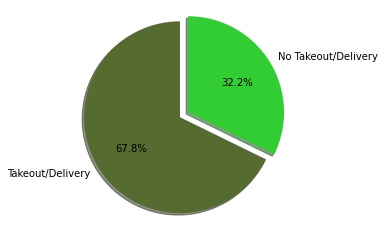

In [40]:
# Graph pie chart displaying proportions of takeout/delivery and no takeout/delivery restaurants

merged_df['pickupordelivery'].value_counts()[0]

labels = 'Takeout/Delivery', 'No Takeout/Delivery'
sizes = [merged_df['pickupordelivery'].value_counts()[0], merged_df['pickupordelivery'].value_counts()[1]]
explode = (0, 0.1) 
colors = ['darkolivegreen','limegreen']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors=colors, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.savefig('data512_a6_3.png')

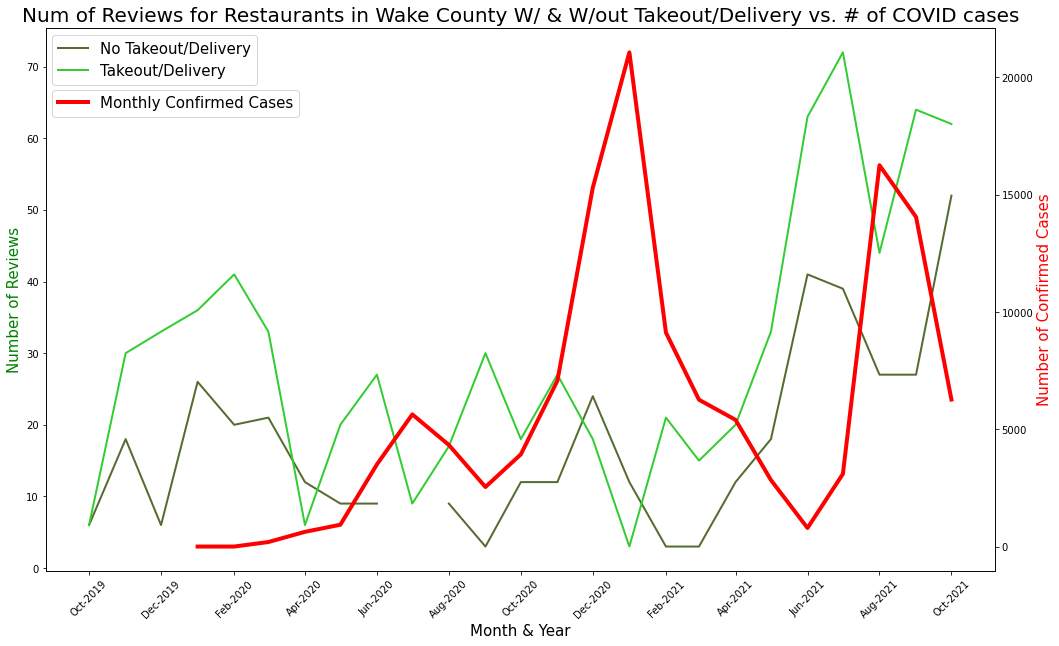

In [41]:
# Plot the first time series graph

fig, ax1 = plt.subplots()

monthyearFmt = mdates.DateFormatter('%b-%Y')

ax1.plot(groupby_count_review['month_year'], groupby_count_review['no'], 'darkolivegreen', label = 'No Takeout/Delivery', linewidth = 2)
ax1.plot(groupby_count_review['month_year'], groupby_count_review['yes'], 'limegreen', label = 'Takeout/Delivery', linewidth = 2)
ax1.xaxis.set_major_formatter(monthyearFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_tick_params(rotation=45)

ax2 = ax1.twinx()
ax2.plot(covid_cases_monthly['month_year'], covid_cases_monthly['Monthly Confirmed Cases'],'r' ,label = 'Monthly Confirmed Cases', linewidth=4)
ax2.xaxis.set_major_formatter(monthyearFmt)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_tick_params(rotation=45)

ax1.set_title('Num of Reviews for Restaurants in Wake County W/ & W/out Takeout/Delivery vs. # of COVID cases', fontsize = 20)
ax1.set_xlabel('Month & Year', fontsize = 15)
ax1.set_ylabel('Number of Reviews', fontsize = 15, color = 'g')
ax2.set_ylabel('Number of Confirmed Cases', fontsize = 15, color='r')

ax1.legend(bbox_to_anchor=(0.23, 1), prop={"size":15})
ax2.legend(bbox_to_anchor=(0.275,0.90), prop={"size":15})

fig.set_size_inches(17, 10)
fig.patch.set_facecolor('white')
fig.savefig('data512_a6_2.png')

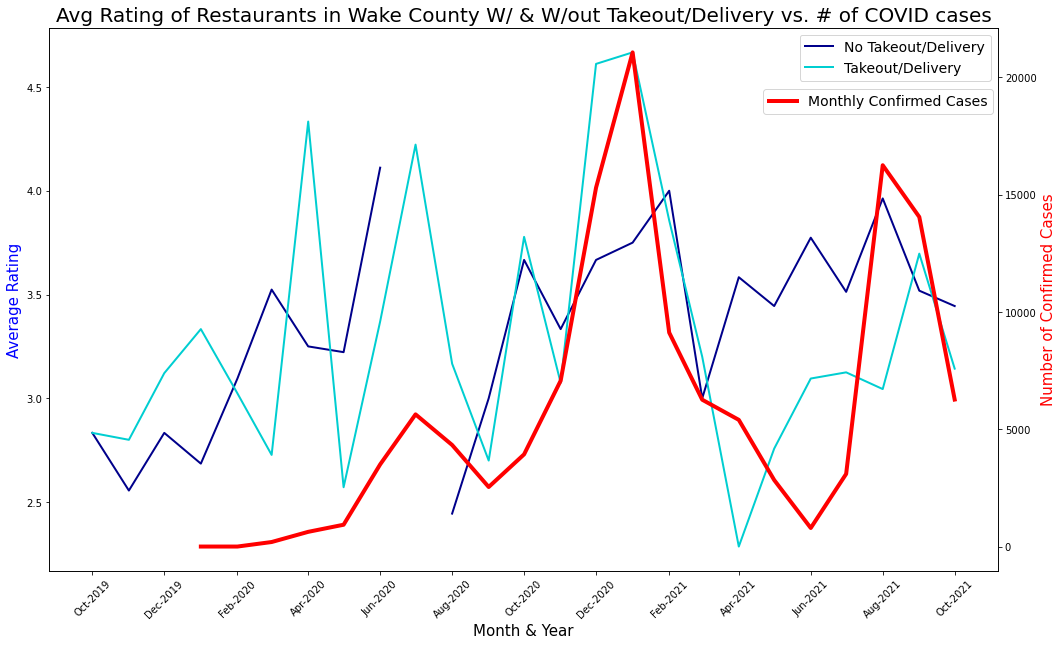

In [42]:
# Plot the second time series graph

fig, ax1 = plt.subplots()

monthyearFmt = mdates.DateFormatter('%b-%Y')

ax1.plot(groupby_avg_rating['month_year'], groupby_avg_rating['no'], 'darkblue', label = 'No Takeout/Delivery', linewidth = 2)
ax1.plot(groupby_avg_rating['month_year'], groupby_avg_rating['yes'], 'darkturquoise', label = 'Takeout/Delivery', linewidth =2)
ax1.xaxis.set_major_formatter(monthyearFmt)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax1.xaxis.set_tick_params(rotation=45)

ax2 = ax1.twinx()
ax2.plot(covid_cases_monthly['month_year'], covid_cases_monthly['Monthly Confirmed Cases'],'r' ,label = 'Monthly Confirmed Cases', linewidth=4)
ax2.xaxis.set_major_formatter(monthyearFmt)
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax2.xaxis.set_tick_params(rotation=45)

ax1.set_title('Avg Rating of Restaurants in Wake County W/ & W/out Takeout/Delivery vs. # of COVID cases', fontsize = 20)
ax1.set_xlabel('Month & Year', fontsize = 15)
ax1.set_ylabel('Average Rating', fontsize = 15, color = 'b')
ax2.set_ylabel('Number of Confirmed Cases', fontsize = 15, color='r')
ax1.legend(bbox_to_anchor=(1, 1), prop={"size":14})
ax2.legend(bbox_to_anchor=(0.745,0.90), prop={"size":14})

fig.set_size_inches(17, 10)
fig.patch.set_facecolor('white')

fig.savefig('data512_a6.png')